In [ ]:
import math
import random
import requests
import time

import numpy as np
import torch
import torchvision

import matplotlib.pyplot as plt
import torch.nn.functional as F

from io import BytesIO
from PIL import Image

# Lakota AI Code Camp Lesson 13: Introduction to Neural Networks III - LeNet

Today, we're going to use the activation functions and the layers we learned about earlier to reproduce the neural network LeNet, that we talked about earlier.

It won't be a perfectly accurate reproduction, because there were techniques the authors used to reduce the number of connections between neurons.
Further, I cannot find the software library used to actually train the neural network.

We're going to go through the model and implement it as faithfully as possible, then we're going to add some improvements, to see if that helps.

After LeCun et al. trained their network, they had a loss of $2.5 \times 10^{-3}$ on the training set and $1.8 \times 10^{-2}$ on the test set.
Additionally, they misclassified 0.14\% of the examples on the training set and 5.0\% on the test set.

We need to talk about one-hot encoding as well, before we move onto the model.
Probability vectors were mentioned earlier.
These are typically what your model outputs, when you are working with categorical variables.

If we input an image and want to predict what category these are, we usually try to predict the probability of each category.
We can view the categorization in a new light.
Since, we know the category, then the probability that it's the correct one is 1.

In the case of prediciting digits, we have 10 categories: 0, 1, 2, 3, 4, 5, 6, 7, 8, and 9.
If our label is 5, then our output vector would be:
$$
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0].
$$
We don't have to have 5 in the 5th (as programmers reckon) place, but we do require the place to be fixed.

To explain this more, suppose that we want to predict one of the four letters $A, B, C, D$.
Then we could one-hot encode it as:
$$
A \to [1, 0, 0, 0]
$$
$$
B \to [0, 1, 0, 0]
$$
$$
C \to [0, 0, 1, 0]
$$
$$
D \to [0, 0, 0, 1]
$$
Again, we don't have to have this correspondence.
We could have another one, such as
$$
A \to [0, 1, 0, 0]
$$
$$
B \to [0, 0, 0, 1]
$$
$$
C \to [0, 0, 1, 0]
$$
$$
D \to [1, 0, 0, 0]
$$
The important thing is that once we decide on this correspondence, then it needs to be fixed.
One data structure that can help with this is the `dict` class:

In [ ]:
class_dict = {'A': np.array([1, 0, 0, 0]),
              'B': np.array([0, 1, 0, 0]),
              'C': np.array([0, 0, 1, 0]),
              'D': np.array([0, 0, 0, 1])}

class_dict

How would we make this into a function?
We want to take in classes and output a correspondence between the classes and the one-hot encoding.

*   What do you think a good name would be?
*   What should the inputs be?
*   What should the ouptuts be?

We're going to work on this question together right now.

`def one_hot(): pass`

Or the too clever way:

In [ ]:
def one_hot(classes):
    num_classes = len(classes)
    ident = np.eye(num_classes)

    class_dict = {classes[i]: ident[i] for i in range(num_classes)}

    return class_dict

In [ ]:
one_hot(['A', 'B', 'C', 'D'])

Now, back to the model, we want the LeNet model to output a $10$-dimensional vector, because there are 10 classes that we want to predict: the 10 digits.

In [ ]:
class_list = list(range(10))

In [ ]:
def imshow(img, label=None, class_list=class_list):
    # Pytorch has images in Channel x height x width, this converts to h x w x c
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2470, 0.2435, 0.2616])
    # undo the normalization
    img = std * img + mean
    # ensure that array is in the proper range to show the image.
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if label is not None:
        # label is assumed to be a (1, ) tensor
        label = label.item()
        label = class_list[label]
        plt.title(label)
    plt.pause(0.001)

In [ ]:
normalize_ds = torchvision.datasets.MNIST(root='./data',
                                            train=True,
                                            download=True,
                                            transform=torchvision.transforms.ToTensor(),
                                            )
normalize_dl = torch.utils.data.DataLoader(normalize_ds,
                                           batch_size=len(normalize_ds),
                                           shuffle=True,
                                           num_workers=0)

100%|██████████| 9912422/9912422 [00:00<00:00, 317791520.44it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 114494984.71it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 195790034.73it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 15059706.54it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
for data, _ in normalize_dl:
    mean = torch.mean(data, (0, 2, 3))
    std = torch.std(data, (0, 2, 3))

In [ ]:
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize(mean=mean, std=std),
    ]
)

In [ ]:
train_ds = torchvision.datasets.MNIST(root='./data', train=True, transform=transform)
test_ds = torchvision.datasets.MNIST(root='./data', train=False, transform=transform)

In [ ]:
train_loader = torch.utils.data.DataLoader(train_ds,
                                          batch_size=len(train_ds),
                                          shuffle=True,
                                          num_workers=0,
                                          pin_memory=False)
test_loader = torch.utils.data.DataLoader(test_ds,
                                          batch_size=len(test_ds),
                                          shuffle=True,
                                          num_workers=0,
                                          pin_memory=False)

In [ ]:
class LeNet(torch.nn.Module):

    def __init__(self):
        super().__init__()

        self.conv1 = torch.nn.Conv2d(in_channels=1,
                                     out_channels=6,
                                     kernel_size=5,
                                     padding=2)
        self.conv2 = torch.nn.Conv2d(in_channels=6,
                                     out_channels=16,
                                     kernel_size=5)
        self.pool = torch.nn.AvgPool2d(kernel_size=2,
                                       stride=2)
        self.fc1 = torch.nn.Linear(in_features=400,
                                   out_features=120)
        self.fc2 = torch.nn.Linear(in_features=120,
                                   out_features=84)
        self.fc3 = torch.nn.Linear(in_features=84,
                                   out_features=10)
        self.activation = torch.tanh

    def forward(self, x):
        x = self.conv1(x)
        x = self.activation(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.activation(x)
        x = self.pool(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        x = self.activation(x)
        x = self.fc3(x)
        x = self.activation(x)
        return x

In [ ]:
model = LeNet()

In [ ]:
images, classes = next(iter(train_loader))

In [ ]:
images.shape

torch.Size([60000, 1, 28, 28])

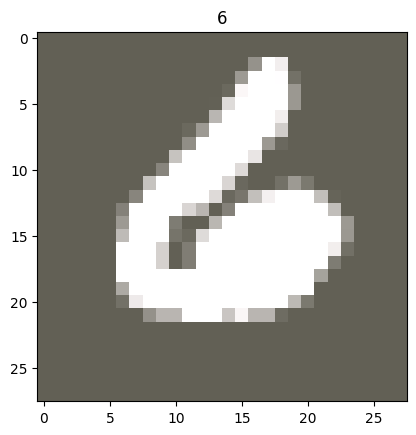

In [ ]:
num = np.random.randint(low=0, high=len(train_ds))
imshow(images[num], classes[num])

In [ ]:
def make_prediction(model, image, class_list=class_list):
    # If shape is not
    image = image.unsqueeze(0)
    pred = model(image)
    pred = torch.argmax(pred)
    return class_list[pred]

In [ ]:
make_prediction(model, images[num])

1

We downloaded the training set, looked at an image, and found that our model makes incorrect predictions.
We're going to change that by training.

In [ ]:
def train(model, train_loader, criterion, opt, epochs=10):
    history = []
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    print("Epoch | Batch | Time(s) | Loss")
    print("------------------------------")

    step = 0

    for epoch in range(epochs):
        running_loss = 0.0
        t = time.time()

        for i, (inputs, label) in enumerate(train_loader, 0):
            inputs, label = inputs.to(device), label.to(device)

            opt.zero_grad(set_to_none=True)

            outputs = model(inputs)

            label = F.one_hot(label, num_classes=10)
            label = label.type(torch.float)

            loss = criterion(outputs, label)

            loss.backward()
            opt.step()

            running_loss += loss.item()
            step += 1
            history.append((step, loss))

        t = time.time() - t
        print(f"{epoch + 1:5d} | {i:5d} | {int(t):8d} | {running_loss:.5f}")
        running_loss = 0

    return history

In [ ]:
def evaluate(model, testloader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, label in test_loader:
            inputs, label = inputs.to(device), label.to(device)
            outputs = model(inputs)

            _, predicted = torch.max(outputs.data, 1)
            total += label.size(0)
            correct += (predicted == label).sum().item()

    print(f'Accuracy of the network on 10000 test images: {100 * correct // total} %')
    return 100 * correct // total

In the original paper, LeCun et al. used mean squared error, which is defined by
$$
\frac{1}{n} \sum_{i = 1}^{n} \left(y_{i} - \widehat{y}_{i}\right)^{2}
$$
here, $n$ is the number of samples, $y_{i}$ is the actual label, and $\widehat{y}_{i}$ is the predicted label.

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
model = model.to(device)

criterion = torch.nn.MSELoss()
opt = torch.optim.SGD(model.parameters(), lr=1e-1, momentum=0.9)

cuda:0


In [ ]:
evaluate(model, test_loader)

Accuracy of the network on 10000 test images: 13 %


13

In [ ]:
history = train(model, train_loader, criterion, opt, epochs=10)

Epoch | Batch | Time(s) | Loss
------------------------------
    1 |     0 |       14 | 0.11546
    2 |     0 |       14 | 0.11324
    3 |     0 |       19 | 0.10937
    4 |     0 |       20 | 0.10458
    5 |     0 |       15 | 0.09960
    6 |     0 |       14 | 0.09505
    7 |     0 |       14 | 0.09134
    8 |     0 |       14 | 0.08869
    9 |     0 |       15 | 0.08709
   10 |     0 |       15 | 0.08636


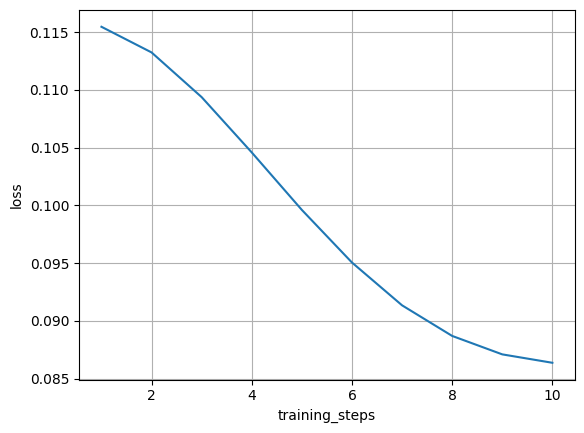

In [ ]:
training_steps = np.array([step for step, _ in history])
loss = np.array([loss.item() for _, loss in history])

fig, ax = plt.subplots()
ax.plot(training_steps, loss)

ax.set(xlabel='training_steps', ylabel='loss')
ax.grid()
plt.show()

In [ ]:
evaluate(model, test_loader)

Accuracy of the network on 10000 test images: 35 %


35

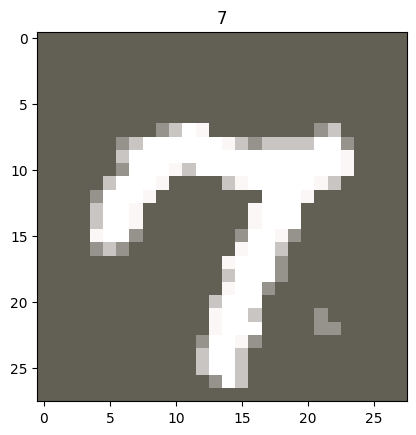

In [ ]:
num = np.random.randint(low=0, high=len(train_ds))
imshow(images[num], classes[num])

In [ ]:
print(make_prediction(model, images[num].to(device)), class_list[classes[num]])

7 7
